# Advanced Usage of reLAISS
### Authors: Evan Reynolds and Alex Gagliano

## Introduction

This notebook demonstrates advanced features of the reLAISS library for finding similar astronomical transients. While the basic_usage.ipynb notebook covered the fundamental functionality, here we'll explore more sophisticated techniques that give you greater flexibility and power in your analysis.

These advanced features allow you to customize how reLAISS processes and analyzes data, including dimensionality reduction, theorized lightcurves, host galaxy swapping, fine-tuning of algorithm parameters, visualization tools, and advanced anomaly detection.

## Topics Covered
1. Using PCA for dimensionality reduction
2. Creating and using theorized lightcurves
3. Swapping host galaxies
4. Setting maximum neighbor distances
5. Tweaking ANNOY parameters
6. Making corner plots
7. Advanced anomaly detection with parameter tuning
8. Host swapping in anomaly detection

## Setup

First, let's import the necessary packages and create the required directories:

In [1]:
import os
import pandas as pd
import numpy as np
import relaiss as rl
import astropy.units as u
import matplotlib.pyplot as plt

# Create output directories
os.makedirs('./figures', exist_ok=True)
os.makedirs('./sfddata-master', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./timeseries', exist_ok=True)

def create_theorized_lightcurve():
    """Create a simple theorized lightcurve for demonstration."""
    # Create a simple Gaussian lightcurve
    times = np.linspace(-20, 50, 50)  # Days relative to peak
    g_mags = 18 - 5 * np.exp(-(times**2) / (2 * 15**2))  # Gaussian with peak at mag 18
    r_mags = 19 - 4 * np.exp(-(times**2) / (2 * 20**2))  # Gaussian with peak at mag 19
    
    # Create DataFrame in the format expected by reLAISS
    g_data = pd.DataFrame({
        'ant_mjd': times + 59000,  # Add offset to get realistic MJD values
        'ant_mag': g_mags,
        'ant_magerr': np.ones_like(times) * 0.1,  # Constant uncertainty
        'ant_passband': ['g'] * len(times),  # Antares passband
        'ant_ra': np.full_like(times, 180.0, dtype=float),  # RA in degrees
        'ant_dec': np.full_like(times, 45.0, dtype=float),  # Dec in degrees
    })
    
    r_data = pd.DataFrame({
        'ant_mjd': times + 59000,  # Add offset to get realistic MJD values
        'ant_mag': r_mags,
        'ant_magerr': np.ones_like(times) * 0.1,  # Constant uncertainty
        'ant_passband': ['R'] * len(times),  # Antares passband - R uppercase for r-band
        'ant_ra': np.full_like(times, 180.0, dtype=float),  # RA in degrees
        'ant_dec': np.full_like(times, 45.0, dtype=float),  # Dec in degrees
    })
    
    # Combine g and r band data
    lc_df = pd.concat([g_data, r_data], ignore_index=True)
    
    return lc_df

## Initialize the ReLAISS Client

We'll start by creating a ReLAISS client instance:

In [2]:
# Initialize the client
client_pca = rl.ReLAISS()

## 1. Using PCA for Dimensionality Reduction

PCA (Principal Component Analysis) can be used to reduce the dimensionality of the feature space while preserving most of the variance. This has several benefits:

- Improves search speed by reducing the computational complexity
- Potentially reduces noise in the feature space
- Helps mitigate the "curse of dimensionality" for high-dimensional data

To use PCA, we set `use_pca=True` in the `load_reference` method and specify the number of components to keep:

Loading preprocessed reference bank from cache...
Building search index...
No host features provided. Running lightcurve-only LAISS with 19 features.
Building new ANNOY index with 25515 transients...
Done!

Loading saved PCA model from /Users/alexgagliano/.relaiss/cache/indices/re_laiss_annoy_index_pcaTrue_10comps_19lc_0host_1weight_pca.joblib
Loaded index with 25515 items
Loading previously saved ANNOY PCA=10 index: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_annoy_index_pcaTrue_10comps_19lc_0host_1weight.ann 


Found input transient at index 0, removing it...

ANN elapsed time: 0.031 s
Total elapsed time: 0.031 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...


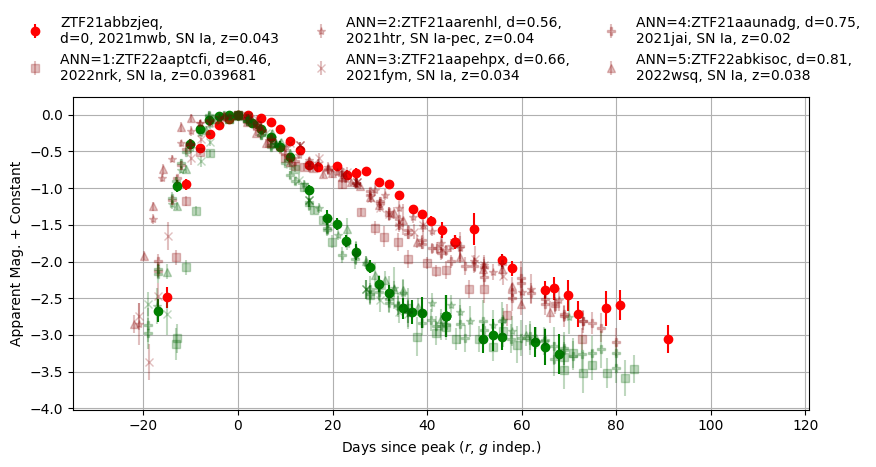


Generating hosts grid plot...


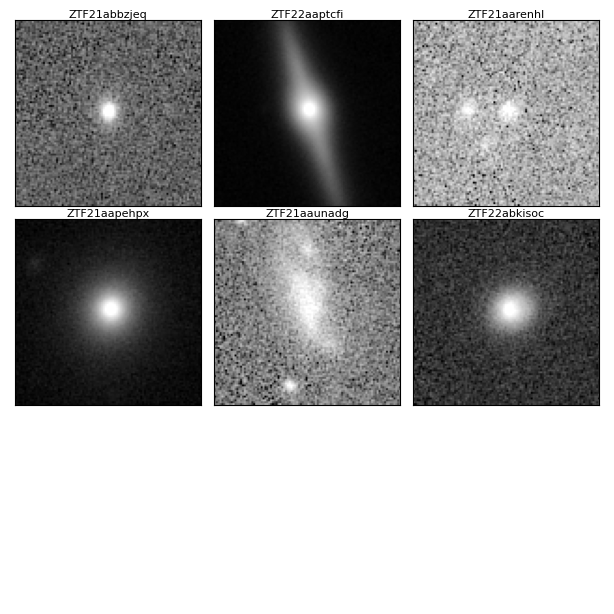

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF22aaptcfi  2022nrk  SN Ia        0.040  0.461  https://alerce.online/object/ZTF22aaptcfi
2    ZTF21aarenhl  2021htr  SN Ia-pec    0.040  0.556  https://alerce.online/object/ZTF21aarenhl
3    ZTF21aapehpx  2021fym  SN Ia        0.034  0.659  https://alerce.online/object/ZTF21aapehpx
4    ZTF21aaunadg  2021jai  SN Ia        0.020  0.750  https://alerce.online/object/ZTF21aaunadg
5    ZTF22abkisoc  2022wsq  SN Ia        0.038  0.806  https://alerce.online/object/ZTF22abkisoc


In [3]:
client_pca.load_reference(
    path_to_sfd_folder='./sfddata-master',
    use_pca=True,
    host_features=[],
    num_pca_components=10,
    force_recreation_of_index=True
)

neighbors_df = client_pca.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',
    n=5,
    search_k=-1,
    plot=True,
    save_figures=False,
    path_to_figure_directory='./figures'
)

## 2. Creating and Using Theorized Lightcurves

One powerful feature of reLAISS is the ability to use theorized (synthetic) lightcurves in the neighbor search. This allows you to test theoretical models against observed data.

When creating a theorized lightcurve, the DataFrame must have the following columns:
- `ant_mjd`: Modified Julian Date (time)
- `ant_mag`: Magnitude
- `ant_magerr`: Magnitude error
- `ant_passband`: Filter name ('g' for g-band, 'R' for r-band)
- `ant_ra`: Right Ascension (optional)
- `ant_dec`: Declination (optional)

**Important:** When using a theorized lightcurve, you must also provide a `host_ztf_id` parameter to specify which host galaxy to use, since the theorized lightcurve doesn't have an associated host.

Below, we create a simple Gaussian-shaped lightcurve and find its nearest neighbors:

Loading preprocessed reference bank from cache...
Building search index...
Loading previously saved ANNOY index...
Done!

Loaded index with 25515 items
Loading timeseries features from cache...
Loading previously saved ANNOY index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_annoy_index_pcaFalse_19lc_8host_1weight.ann 


ANN elapsed time: 0.294 s
Total elapsed time: 0.294 s

         ZTF ID        IAU Name   Spec           z
INPUT:   [model]       No TNS     ---      -99.000
HOST:    ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/theorized_lc_host_from_ZTF21abbzjeq.png


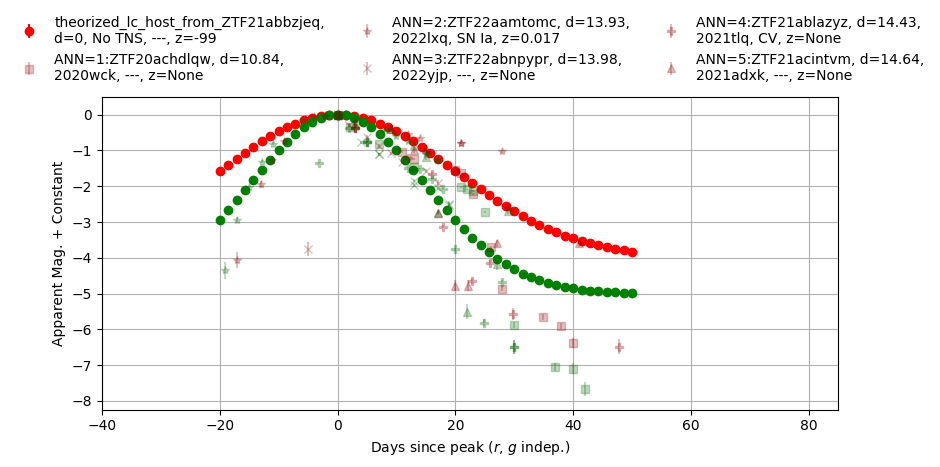


Generating hosts grid plot...


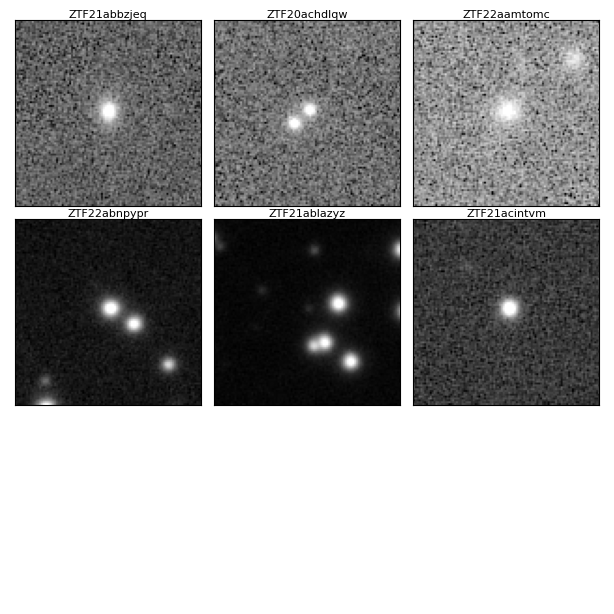

PDF written to figures/host_grids/theorized_lc_host_from_ZTF21abbzjeq_host_thumbnails_ann=5.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF20achdlqw  2020wck  ---        --- 10.839  https://alerce.online/object/ZTF20achdlqw
2    ZTF22aamtomc  2022lxq  SN Ia        0.017 13.932  https://alerce.online/object/ZTF22aamtomc
3    ZTF22abnpypr  2022yjp  ---        --- 13.984  https://alerce.online/object/ZTF22abnpypr
4    ZTF21ablazyz  2021tlq  CV         --- 14.429  https://alerce.online/object/ZTF21ablazyz
5    ZTF21acintvm  2021adxk ---        --- 14.644  https://alerce.online/object/ZTF21acintvm


In [4]:
client_theor = rl.ReLAISS()

client_theor.load_reference(
    path_to_sfd_folder='./sfddata-master',  # Directory for SFD dust maps
    use_pca=False,  # Don't use PCA for this example
    host_features= ["gKronMagCorrected", "gKronRad", "gExtNSigma",  "rKronMagCorrected",  "rKronRad",  "iKronMagCorrected", "zKronMagCorrected", "zKronRad"],
)

# Create a theorized lightcurve
theorized_lc = create_theorized_lightcurve()

# Find neighbors for the theorized lightcurve
# Need to provide a host galaxy when using theorized lightcurve
neighbors_df = client_theor.find_neighbors(
    theorized_lightcurve_df=theorized_lc,
    host_ztf_id='ZTF21abbzjeq',
    n=5,
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

## 3. Swapping Host Galaxies

reLAISS allows you to swap the host galaxy of a transient, which is useful for:

- Exploring how host properties affect the similarity search results
- Investigating the effects of different environments on transient characteristics
- Testing hypotheses about host galaxy influences

Here's how to swap in a different host galaxy:

Loading preprocessed reference bank from cache...
Building search index...
Loading previously saved ANNOY index...
Done!

Loaded index with 25515 items
ZTF19aazefbe not in dataset bank – extracting host features directly.
Using provided preprocessed dataframe to extract time series features...


/Users/alexgagliano/Documents/Teaching/Evan_LAISS/laiss_final/re-laiss/src/relaiss/features.py:489: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lc_timeseries_feat_df = pd.concat(


Extracted lightcurve features for ZTF19aazefbe in 7.31s!
Searching for host galaxy...
Using provided preprocessed dataframe instead of processing raw data
Loading previously saved ANNOY index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_annoy_index_pcaFalse_19lc_19host_1weight.ann 


ANN elapsed time: 0.008 s
Total elapsed time: 0.008 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043
HOST:    ZTF19aazefbe  No TNS     ---      -99.000

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21abbzjeq_host_from_ZTF19aazefbe.png


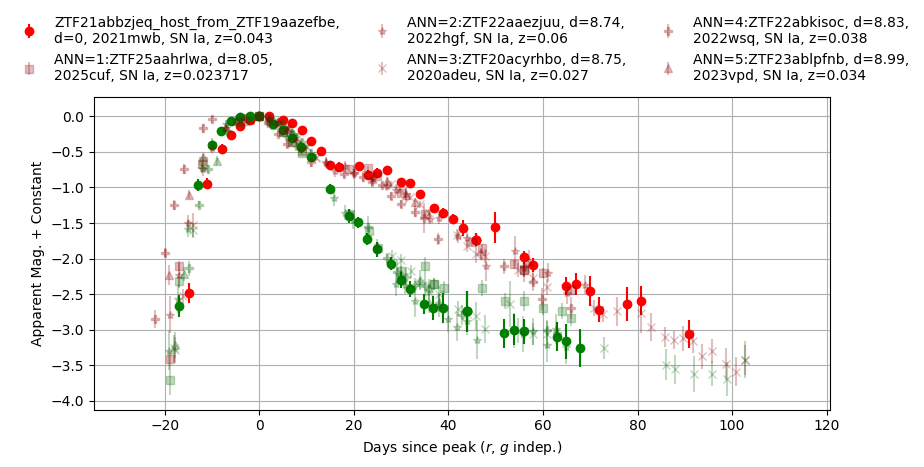


Generating hosts grid plot...


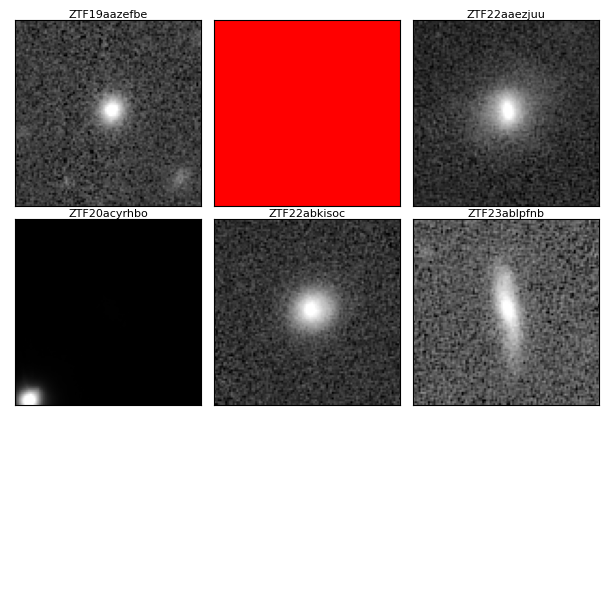

PDF written to figures/host_grids/ZTF21abbzjeq_host_from_ZTF19aazefbe_host_thumbnails_ann=5.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF25aahrlwa  2025cuf  SN Ia        0.024  8.055  https://alerce.online/object/ZTF25aahrlwa
2    ZTF22aaezjuu  2022hgf  SN Ia        0.060  8.742  https://alerce.online/object/ZTF22aaezjuu
3    ZTF20acyrhbo  2020adeu SN Ia        0.027  8.750  https://alerce.online/object/ZTF20acyrhbo
4    ZTF22abkisoc  2022wsq  SN Ia        0.038  8.827  https://alerce.online/object/ZTF22abkisoc
5    ZTF23ablpfnb  2023vpd  SN Ia        0.034  8.987  https://alerce.online/object/ZTF23ablpfnb


In [5]:
# Find neighbors with a swapped host galaxy
client = rl.ReLAISS()

client.load_reference(
    path_to_sfd_folder='./sfddata-master',  # Directory for SFD dust maps
)

neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',  # Source transient
    host_ztf_id='ZTF19aazefbe',  # Host to swap in
    n=5,
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

## 4. Setting Maximum Neighbor Distances

Sometimes you're only interested in neighbors that are truly similar to your target. By setting a maximum distance threshold, you can:

- Filter out neighbors that are too dissimilar
- Focus only on highly confident matches

Note that you might get fewer neighbors than requested if the distance threshold is applied:

Loading previously saved ANNOY index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_annoy_index_pcaFalse_19lc_19host_1weight.ann 


Found input transient at index 0, removing it...

ANN elapsed time: 0.018 s
Total elapsed time: 0.018 s

Found 1 neighbors for distance threshold of 6.
         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21abbzjeq.png


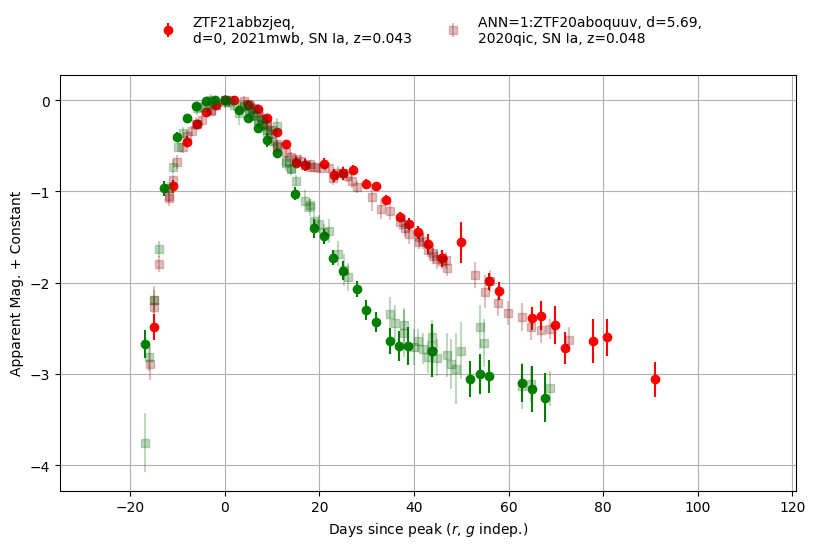


Generating hosts grid plot...


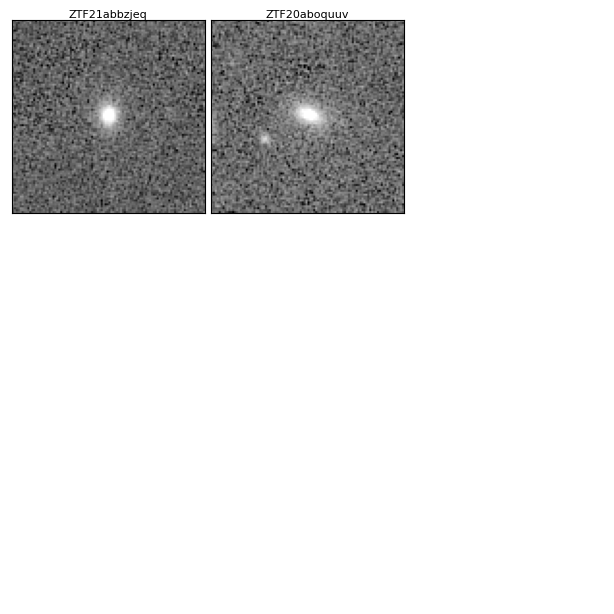

PDF written to figures/host_grids/ZTF21abbzjeq_host_thumbnails_ann=10.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF20aboquuv  2020qic  SN Ia        0.048  5.687  https://alerce.online/object/ZTF20aboquuv
Number of neighbors found: 1


In [6]:
# Find neighbors with maximum distance constraint
neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',
    n=10,
    max_neighbor_dist=6,  # Only return neighbors within this distance
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

print(f"Number of neighbors found: {len(neighbors_df)}")

## 5. Tweaking ANNOY Parameters

ANNOY (Approximate Nearest Neighbors Oh Yeah) is the algorithm used for fast nearest neighbor search. You can tune its parameters to balance search accuracy and speed:

- `search_k`: Controls the number of nodes to explore during search (higher = more accurate but slower)
- `n_trees`: Controls the number of random projection trees built (set during client initialization)

Here's how to adjust the search_k parameter:

Loading previously saved ANNOY index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_annoy_index_pcaFalse_19lc_19host_1weight.ann 


Found input transient at index 0, removing it...

ANN elapsed time: 0.014 s
Total elapsed time: 0.014 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21abbzjeq.png


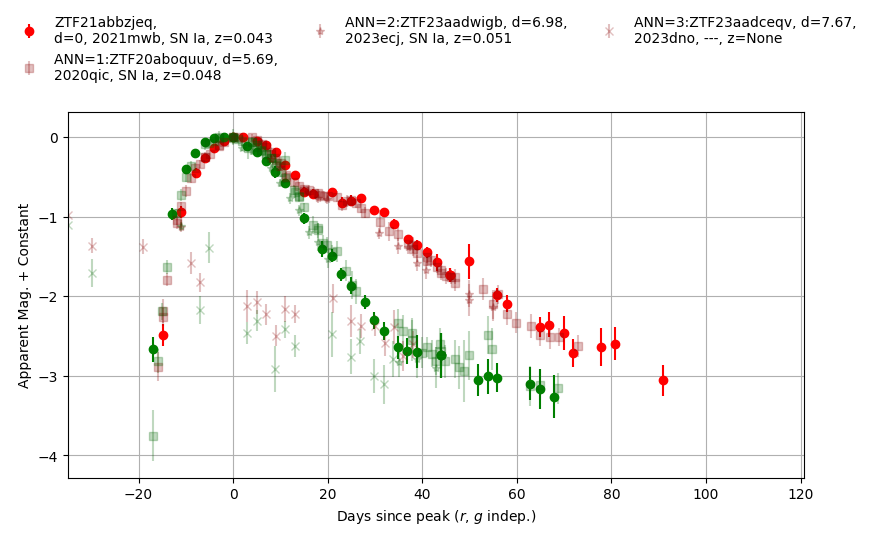


Generating hosts grid plot...


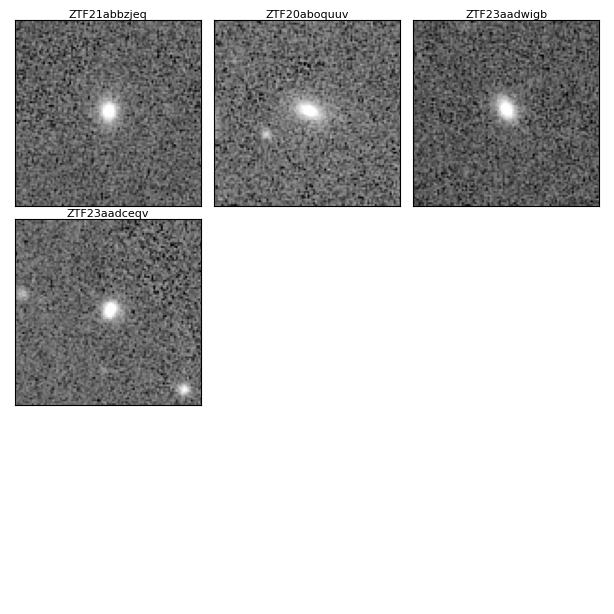

PDF written to figures/host_grids/ZTF21abbzjeq_host_thumbnails_ann=3.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF20aboquuv  2020qic  SN Ia        0.048  5.687  https://alerce.online/object/ZTF20aboquuv
2    ZTF23aadwigb  2023ecj  SN Ia        0.051  6.976  https://alerce.online/object/ZTF23aadwigb
3    ZTF23aadceqv  2023dno  ---        ---  7.667  https://alerce.online/object/ZTF23aadceqv


In [7]:
# Find neighbors with tweaked ANNOY parameters
neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',
    n=3,
    search_k=2000,  # Increase search_k for more accurate results
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)


## 6. Making Corner Plots

Corner plots are a powerful visualization tool that show the distribution of features for the input transient and its neighbors. They can help you:

- Understand which features are driving the similarity matching
- Identify potential correlations between different features
- Visualize the feature space and where your transient sits within it

To create corner plots, we need to first get the primer_dict containing information about the input transient:

Loading previously saved ANNOY index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_annoy_index_pcaFalse_19lc_19host_1weight.ann 


Found input transient at index 0, removing it...

ANN elapsed time: 0.014 s
Total elapsed time: 0.014 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21abbzjeq.png


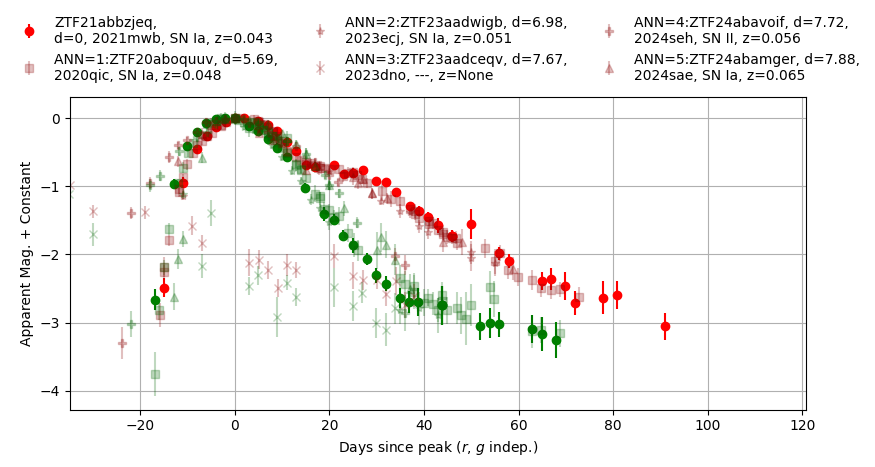


Generating hosts grid plot...


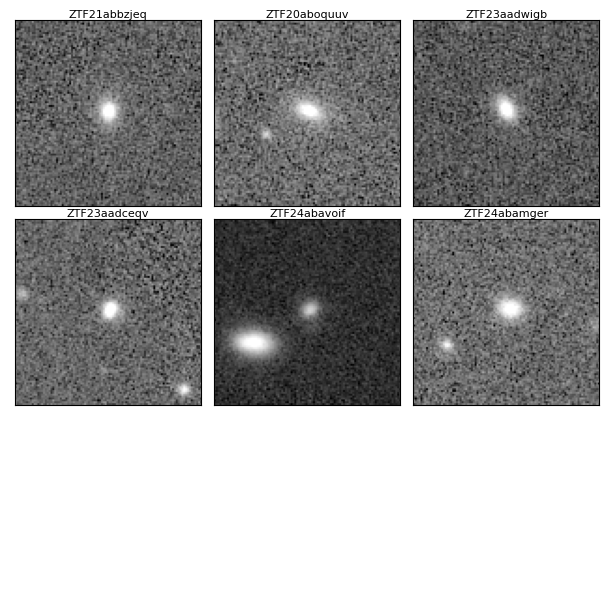

PDF written to figures/host_grids/ZTF21abbzjeq_host_thumbnails_ann=5.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF20aboquuv  2020qic  SN Ia        0.048  5.687  https://alerce.online/object/ZTF20aboquuv
2    ZTF23aadwigb  2023ecj  SN Ia        0.051  6.976  https://alerce.online/object/ZTF23aadwigb
3    ZTF23aadceqv  2023dno  ---        ---  7.667  https://alerce.online/object/ZTF23aadceqv
4    ZTF24abavoif  2024seh  SN II        0.056  7.720  https://alerce.online/object/ZTF24abavoif
5    ZTF24abamger  2024sae  SN Ia        0.065  7.885  https://alerce.online/object/ZTF24abamger
Using provided preprocessed dataframe for corner plots
Total number of transients for corner plots: 25515
Creating corner plot for lc_group_1...
Total number of transients for corner plot after outlier removal: 19985


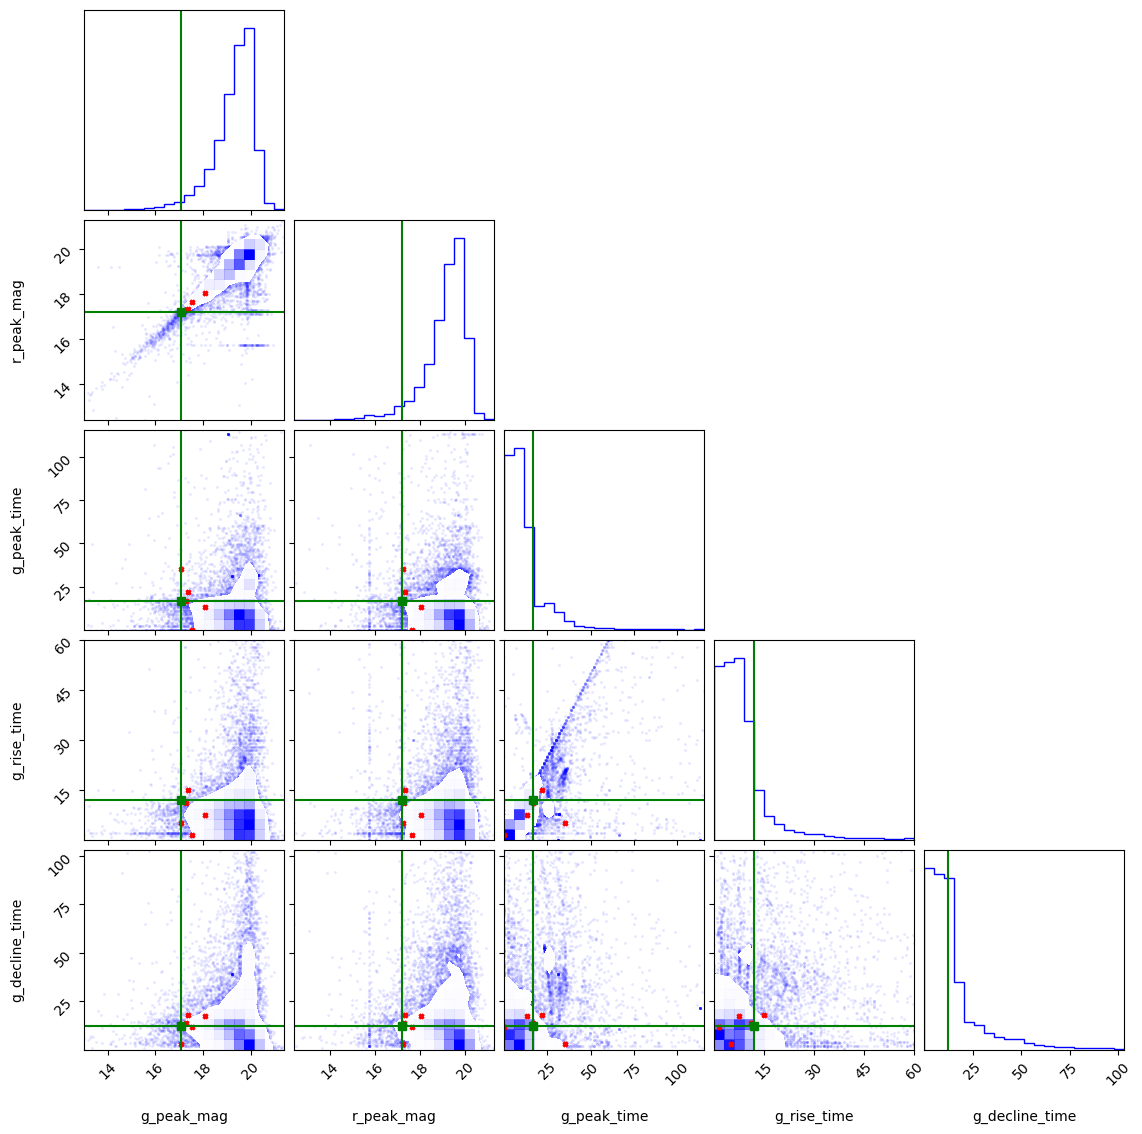

Creating corner plot for lc_group_2...
Total number of transients for corner plot after outlier removal: 17957


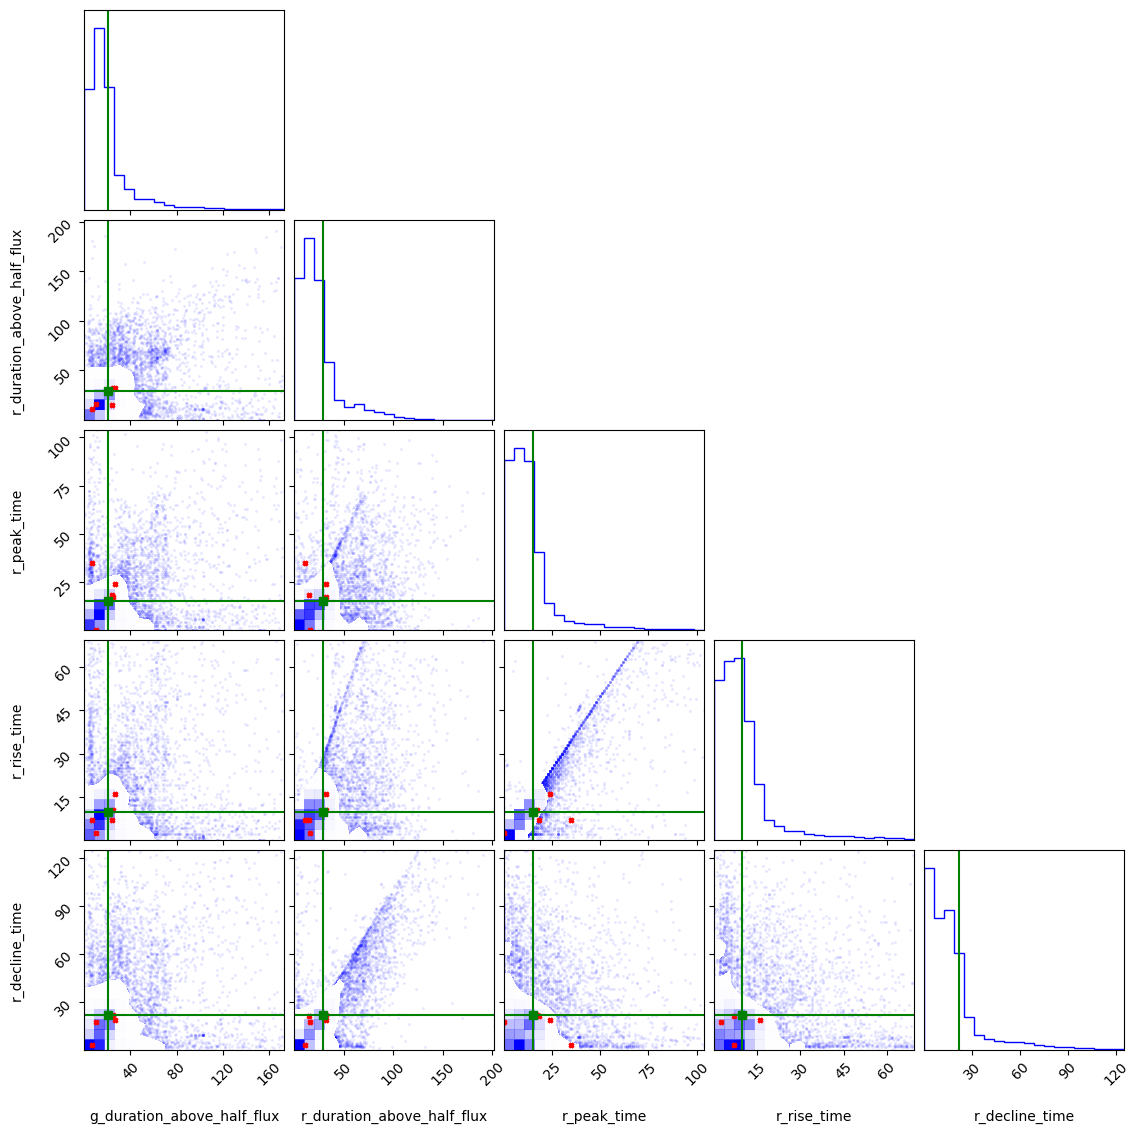

Creating corner plot for lc_group_3...
Total number of transients for corner plot after outlier removal: 23120


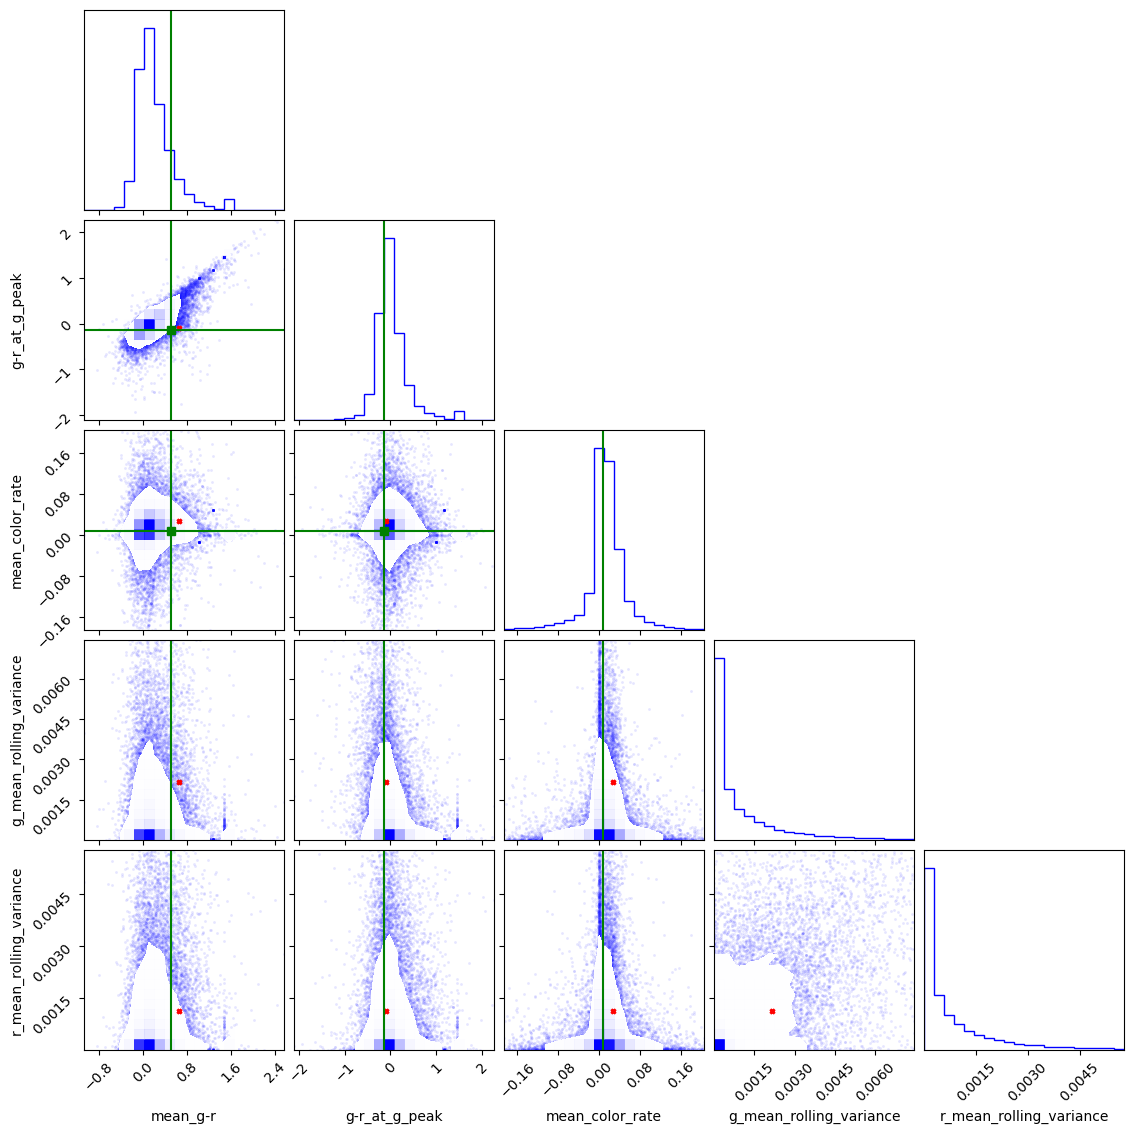

Creating corner plot for lc_group_4...
Total number of transients for corner plot after outlier removal: 20712


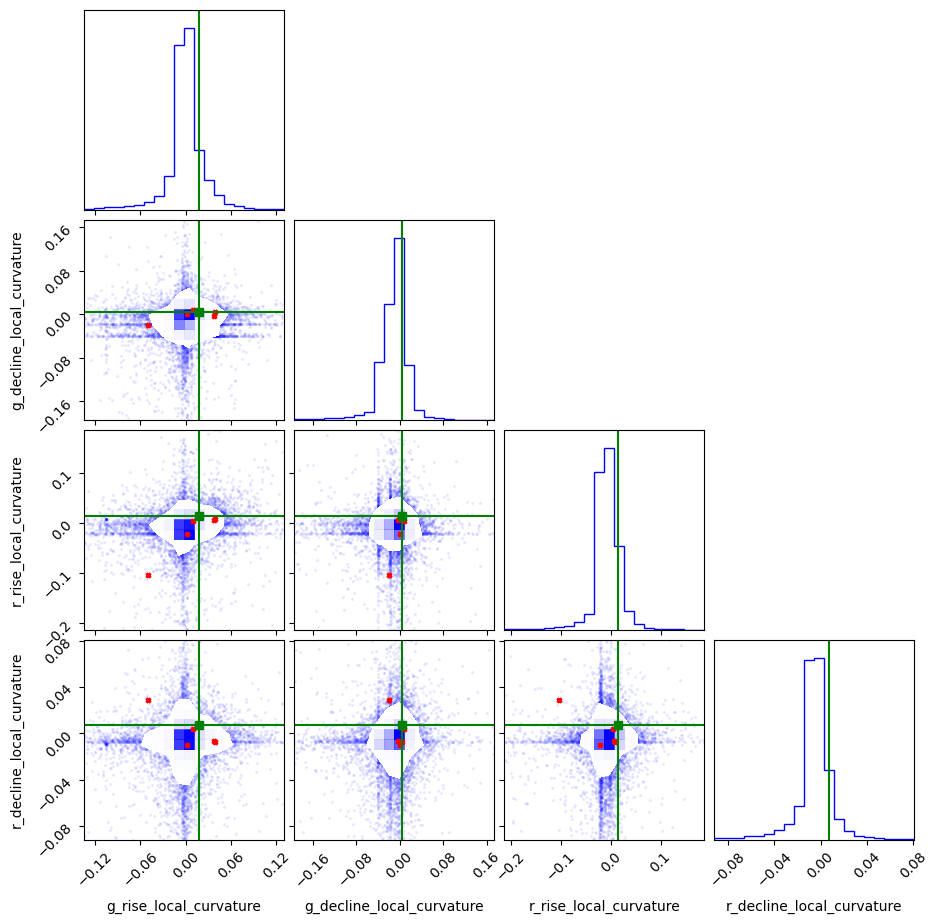

Creating corner plot for host_group_1...
Total number of transients for corner plot after outlier removal: 24671


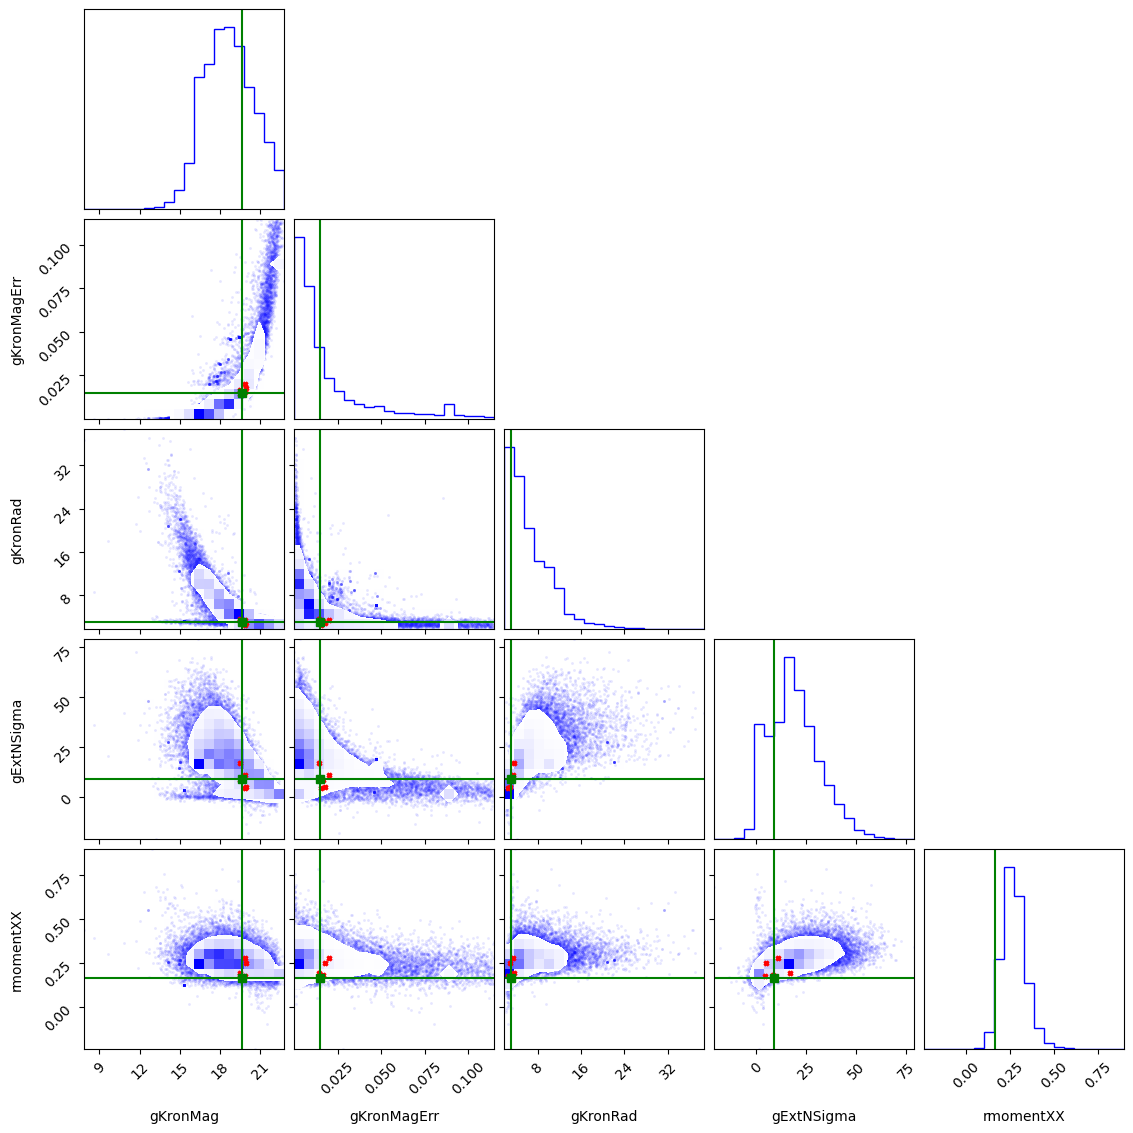

Creating corner plot for host_group_2...
Total number of transients for corner plot after outlier removal: 24473


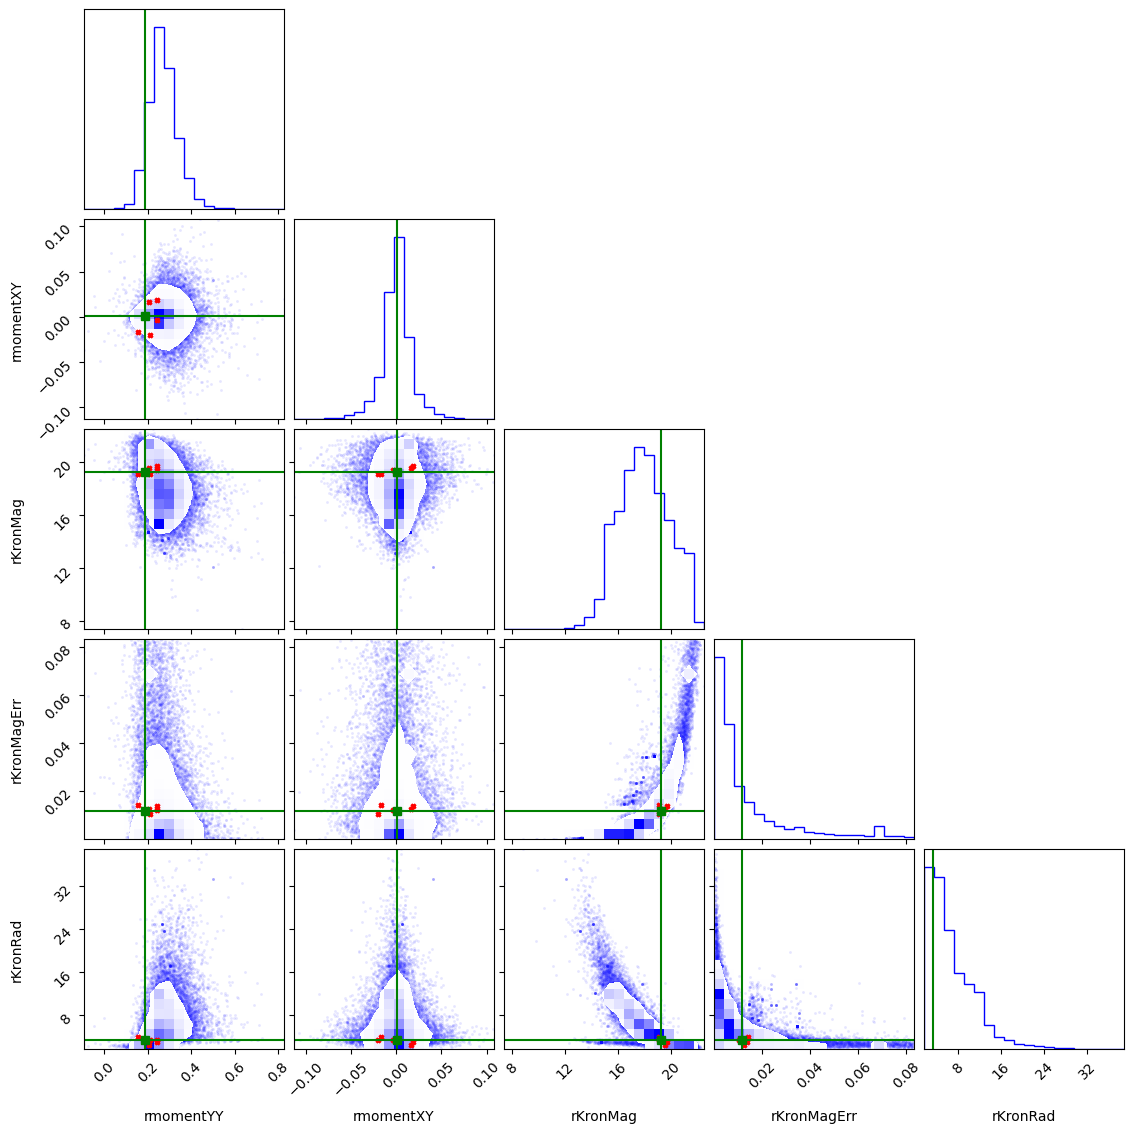

Creating corner plot for host_group_3...
Total number of transients for corner plot after outlier removal: 24552


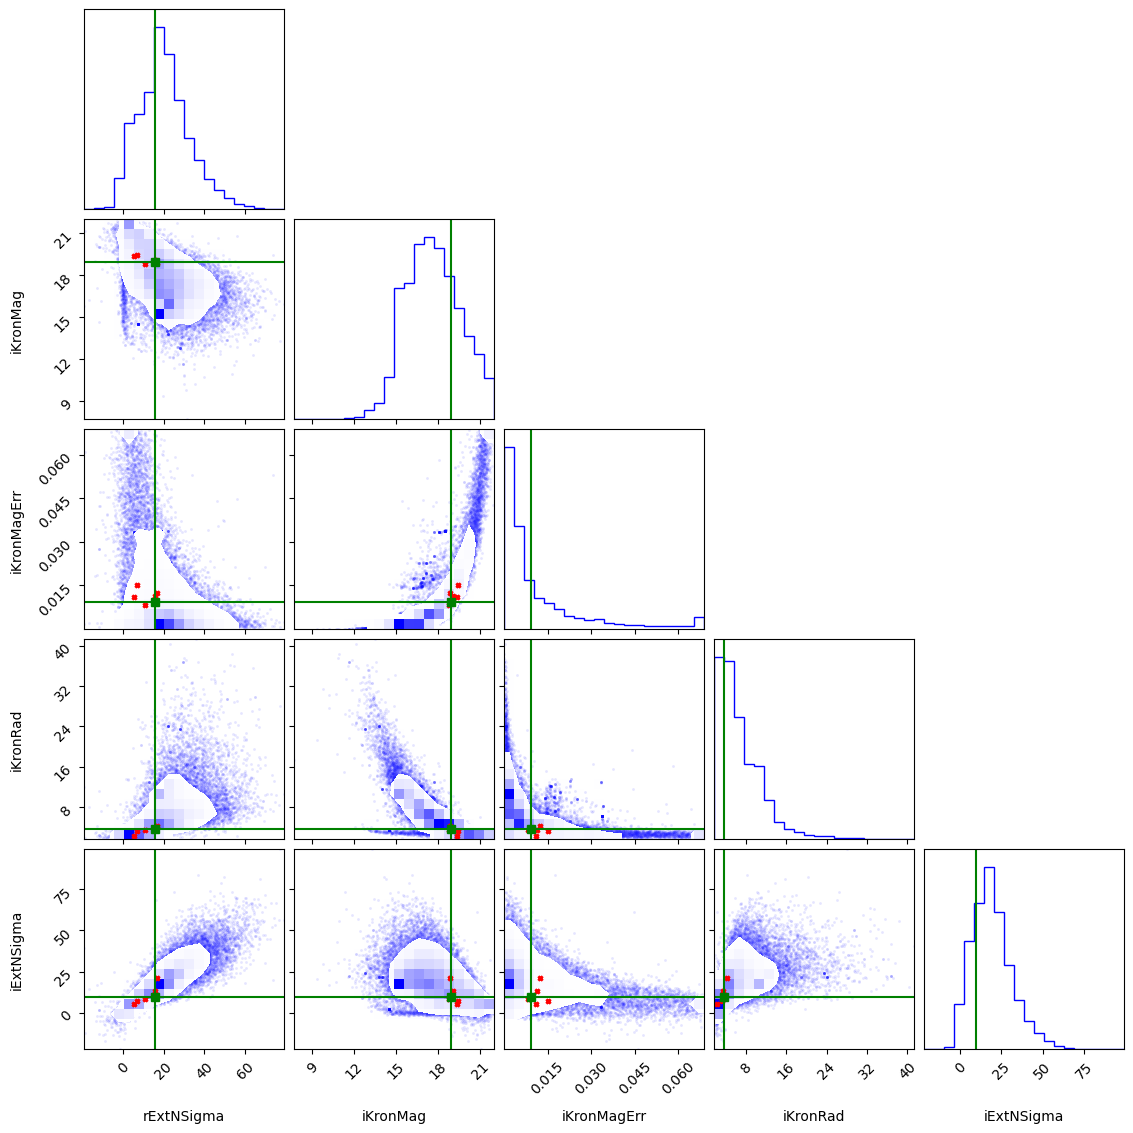

Creating corner plot for host_group_4...
Total number of transients for corner plot after outlier removal: 24088


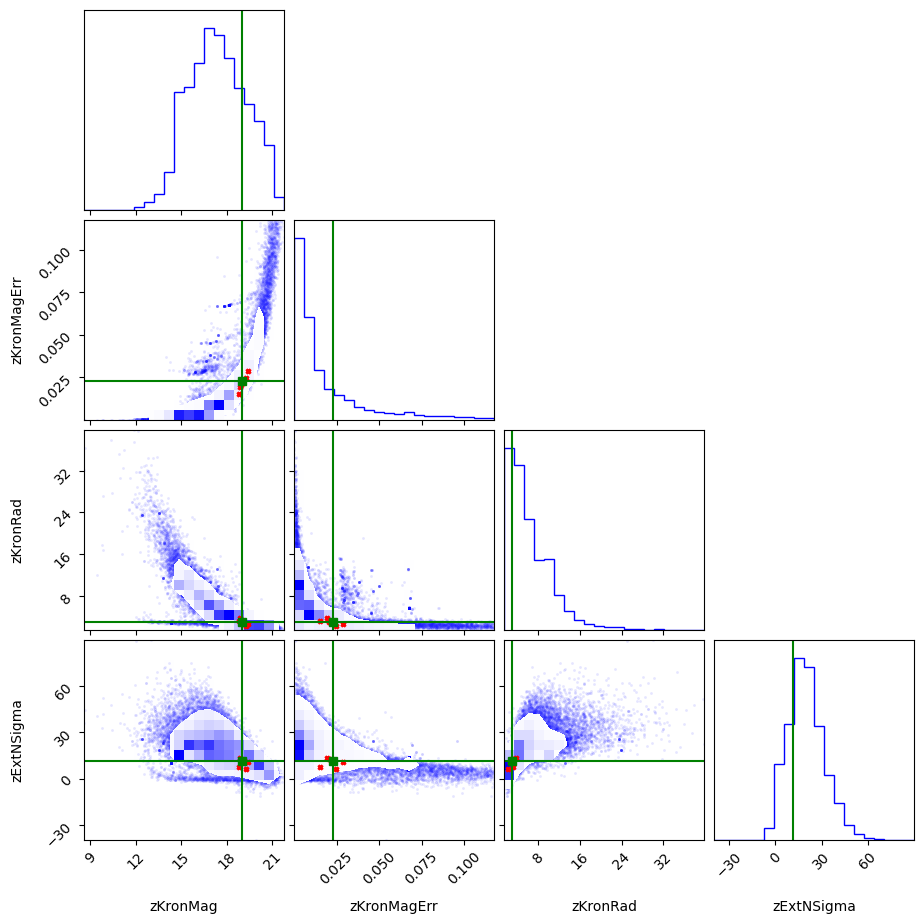

Corner plots saved to./figures/corner_plots
Corner plots saved to ./figures/


In [8]:
# Get neighbors from a new search
neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',
    n=5,
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

# Get primer_dict separately
from relaiss.search import primer
primer_dict = primer(
    lc_ztf_id='ZTF21abbzjeq',
    theorized_lightcurve_df=None,
    host_ztf_id=None,
    dataset_bank_path=client.bank_csv,
    path_to_timeseries_folder='./',
    path_to_sfd_folder=client.path_to_sfd_folder,
    lc_features=client.lc_features,
    host_features=client.host_features,
    num_sims=0,
    save_timeseries=False,
    preprocessed_df=client.get_preprocessed_dataframe()  # Use the preprocessed dataframe
)

# Create corner plots using the primer_dict
from relaiss.plotting import corner_plot
corner_plot(
    neighbors_df=neighbors_df,
    primer_dict=primer_dict,
    path_to_dataset_bank=client.bank_csv,
    path_to_figure_directory='./figures',
    save_plots=True,
    preprocessed_df=client.get_preprocessed_dataframe()  # Use the preprocessed dataframe
)
print("Corner plots saved to ./figures/")

## 7. Advanced Anomaly Detection with Parameter Tuning

The anomaly detection module in reLAISS uses an Isolation Forest algorithm that can be tuned for different scenarios. Key parameters include:

- `n_estimators`: Number of base estimators (trees) in the ensemble
- `contamination`: Expected proportion of outliers in the dataset
- `max_samples`: Number of samples drawn to train each base estimator

Let's explore how different parameters affect the model's performance:


Running anomaly detection with default model...
Running Anomaly Detection:

Training new Isolation Forest model...
Loading and preprocessing dataset bank for AD...
Model saved to: ./models/IForest_n=100_c=0.02_m=256_lc=19_host=19.pkl

Rebuilding timeseries dataframe(s) for AD...
Loading timeseries from ./timeseries/ZTF21abbzjeq_timeseries.csv...
Prediction doesn't exceed anom_threshold of 50% for ZTF21abbzjeq.
Saved anomaly detection chart to:./figures/AD_default/AD/ZTF21abbzjeq_AD.pdf


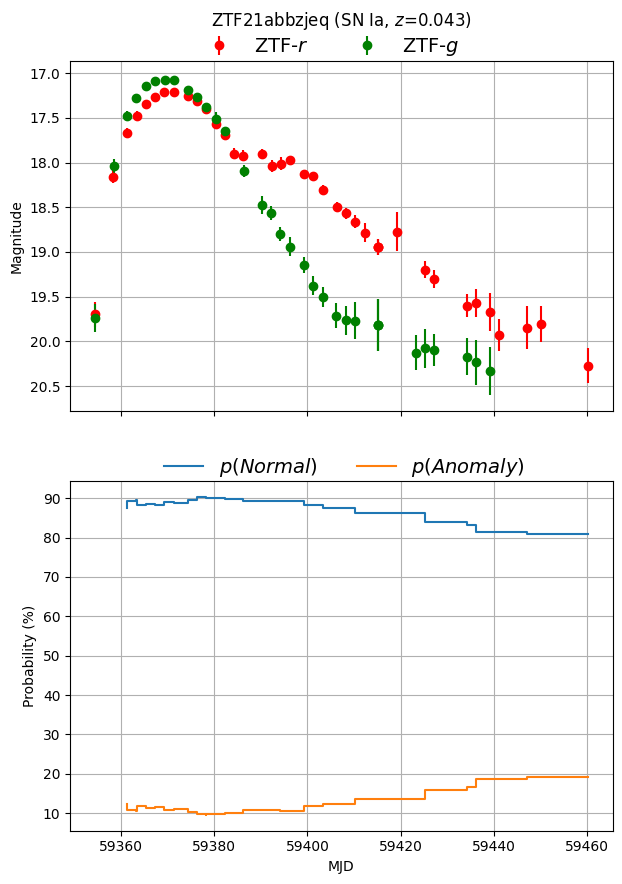


Running with 500 estimators...
Running Anomaly Detection:

Training new Isolation Forest model...
Loading and preprocessing dataset bank for AD...
Model saved to: ./models/IForest_n=500_c=0.02_m=256_lc=19_host=19.pkl

Rebuilding timeseries dataframe(s) for AD...
Loading timeseries from ./timeseries/ZTF21abbzjeq_timeseries.csv...
Prediction doesn't exceed anom_threshold of 50% for ZTF21abbzjeq.
Saved anomaly detection chart to:./figures/AD_default/AD/ZTF21abbzjeq_AD.pdf


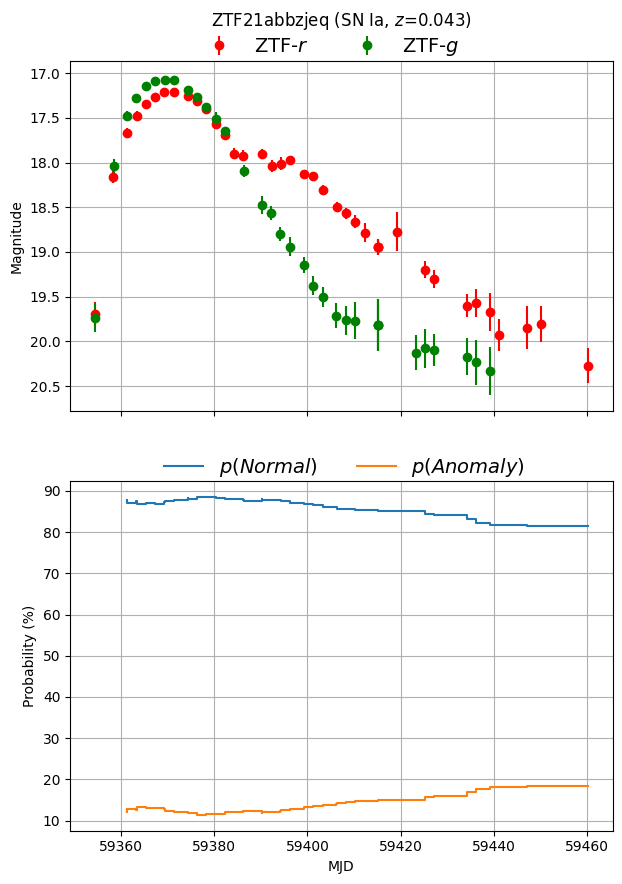


Running with 1024 samples...
Running Anomaly Detection:

Training new Isolation Forest model...
Loading and preprocessing dataset bank for AD...
Model saved to: ./models/IForest_n=100_c=0.02_m=1024_lc=19_host=19.pkl

Rebuilding timeseries dataframe(s) for AD...
Loading timeseries from ./timeseries/ZTF21abbzjeq_timeseries.csv...
Prediction doesn't exceed anom_threshold of 50% for ZTF21abbzjeq.
Saved anomaly detection chart to:./figures/AD_default/AD/ZTF21abbzjeq_AD.pdf


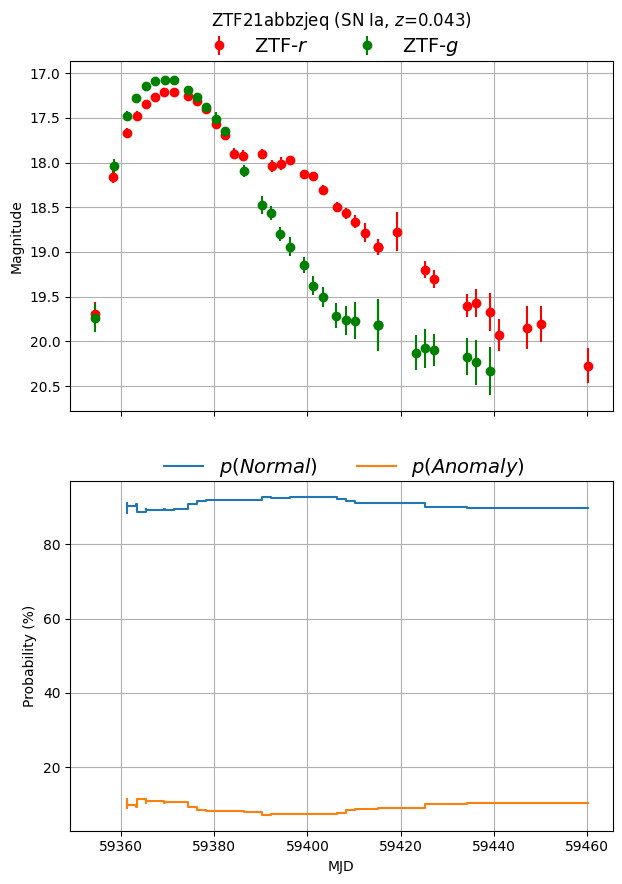

In [9]:
from relaiss.anomaly import train_AD_model, anomaly_detection

queried_transient = "ZTF21abbzjeq"

print("\nRunning anomaly detection with default model...")
anomaly_detection(
    client,
    transient_ztf_id=queried_transient,
    lc_features=client.lc_features,
    host_features=client.host_features,
    path_to_timeseries_folder="./timeseries",
    path_to_sfd_folder='./sfddata-master',
    path_to_dataset_bank=client.bank_csv,
    path_to_models_directory="./models",
    path_to_figure_directory="./figures/AD_default",
    save_figures=True,
    n_estimators=100,
    contamination=0.02,
    max_samples=256,
    force_retrain=True,
    preprocessed_df=client.get_preprocessed_dataframe()  
)

print("\nRunning with 500 estimators...")
anomaly_detection(
    client,
    transient_ztf_id=queried_transient,
    lc_features=client.lc_features,
    host_features=client.host_features,
    path_to_timeseries_folder="./timeseries",
    path_to_sfd_folder='./sfddata-master',
    path_to_dataset_bank=client.bank_csv,
    path_to_models_directory="./models",
    path_to_figure_directory="./figures/AD_default",
    save_figures=True,
    n_estimators=500,
    contamination=0.02,
    max_samples=256,
    force_retrain=True,
    preprocessed_df=client.get_preprocessed_dataframe() 
)


print("\nRunning with 1024 samples...")
anomaly_detection(
    client,
    transient_ztf_id=queried_transient,
    lc_features=client.lc_features,
    host_features=client.host_features,
    path_to_timeseries_folder="./timeseries",
    path_to_sfd_folder='./sfddata-master',
    path_to_dataset_bank=client.bank_csv,
    path_to_models_directory="./models",
    path_to_figure_directory="./figures/AD_default",
    save_figures=True,
    n_estimators=100,
    contamination=0.02,
    max_samples=1024,
    force_retrain=True,
    preprocessed_df=client.get_preprocessed_dataframe() 
)

## 8. Anomaly Detection with Host Swapping

Just as with neighbor searches, you can swap host galaxies for anomaly detection. This helps you understand how host properties contribute to a transient's anomaly score.

This feature is particularly useful for:
- Testing if the anomalous nature of a transient is due to its host galaxy
- Exploring the "what if" scenario of a transient occurring in a different environment
- Separating intrinsic transient anomalies from host-related factors

Running Anomaly Detection:

Loading existing model from ./models/IForest_n=100_c=0.02_m=256_lc=19_host=19.pkl

Rebuilding timeseries dataframe(s) for AD...
Loading timeseries from ./timeseries/ZTF21abbzjeq_timeseries.csv...
Extracting full lightcurve features...


/Users/alexgagliano/Documents/Teaching/Evan_LAISS/laiss_final/re-laiss/src/relaiss/features.py:489: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lc_timeseries_feat_df = pd.concat(
/Users/alexgagliano/Documents/Teaching/Evan_LAISS/laiss_final/re-laiss/src/relaiss/features.py:489: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lc_timeseries_feat_df = pd.concat(


Extracted lightcurve features for ZTF20aacbyec in 3.52s!
Searching for host galaxy...
Host identified.
Engineering features...
Prediction doesn't exceed anom_threshold of 50% for ZTF21abbzjeq with host from ZTF20aacbyec
Saved anomaly detection chart to:./figures/AD_host_swap/AD/ZTF21abbzjeq_w_host_ZTF20aacbyec_AD.pdf


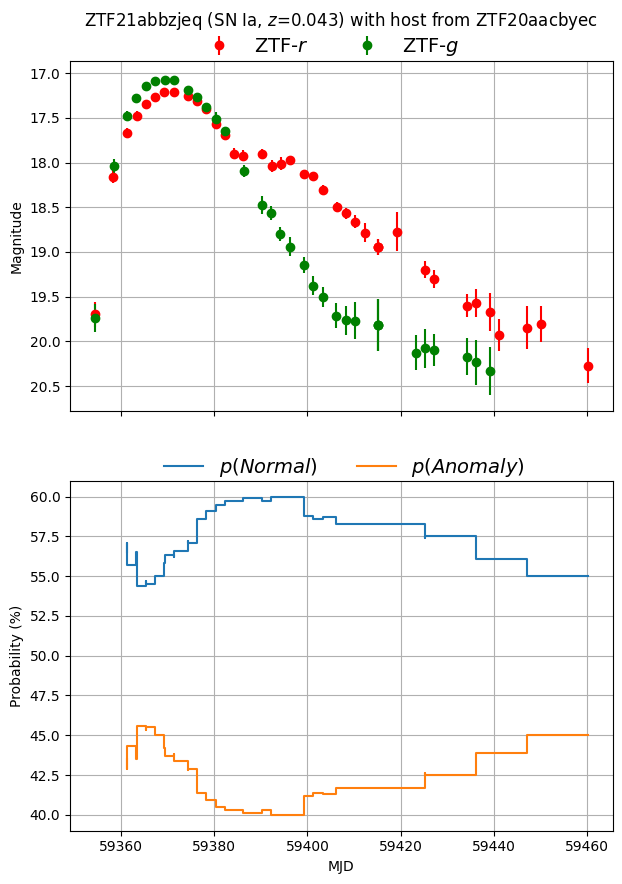

Anomaly detection figures saved to ./figures/AD_default/ and ./figures/AD_host_swap/


In [10]:
# Use the default model but swap in a different host galaxy
anomaly_detection(
    client,
    transient_ztf_id="ZTF21abbzjeq",
    lc_features=client.lc_features,
    host_features=client.host_features,
    path_to_timeseries_folder="./timeseries",
    path_to_sfd_folder='./sfddata-master',
    path_to_dataset_bank=client.bank_csv,
    host_ztf_id_to_swap_in="ZTF20aacbyec",
    path_to_models_directory="./models",
    path_to_figure_directory="./figures/AD_host_swap",
    save_figures=True,
    n_estimators=100,
    contamination=0.02,
    max_samples=256,
    force_retrain=False,
    preprocessed_df=client.get_preprocessed_dataframe()  # Use the preprocessed dataframe
)

print("Anomaly detection figures saved to ./figures/AD_default/ and ./figures/AD_host_swap/")

## Conclusion

By combining these features, you can create highly customized searches tailored to your specific research questions.

For information on how to build your own dataset bank for reLAISS, see the `build_databank.ipynb` notebook.